In [7]:
from __future__ import unicode_literals, print_function, division
import time
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from utils import timeSince

In [3]:
device = torch.device("cpu")
from get_cn_en_pairs import get_training_pairs, SOS_token, EOS_token, MAX_LENGTH, output_lang, input_lang, tensorFromSentence

Reading lines...
Read 29371 sentence pairs
Trimmed to 2160 sentence pairs
Counting words...
Counted words:
cn 1209
en 1431
['他不关心钱 。', 'he is careless about money .']


In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [6]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # input size = output size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # input is pre_hidden and embedding -> hidden_size * 2, output is max sentence length
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        # input is attn_applied (from encoder outoputs) and embedding -> hidden_size * 2 (?)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
hidden_size = 256
encoder0 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder0 = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

In [23]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [25]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = get_training_pairs(n_iters)
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [31]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, True)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


In [32]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [28]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

train_losses = trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

2m 53s (- 40m 31s) (5000 6%) 3.0646
5m 47s (- 37m 37s) (10000 13%) 2.2331
8m 43s (- 34m 54s) (15000 20%) 1.5829
16m 35s (- 45m 36s) (20000 26%) 1.1166
19m 37s (- 39m 14s) (25000 33%) 0.7726
22m 31s (- 33m 47s) (30000 40%) 0.5255
25m 29s (- 29m 7s) (35000 46%) 0.3682
28m 27s (- 24m 54s) (40000 53%) 0.2712
31m 57s (- 21m 18s) (45000 60%) 0.2051
35m 20s (- 17m 40s) (50000 66%) 0.1885
38m 46s (- 14m 5s) (55000 73%) 0.1637
42m 15s (- 10m 33s) (60000 80%) 0.1646
45m 42s (- 7m 1s) (65000 86%) 0.1523
56m 13s (- 4m 0s) (70000 93%) 0.1519
59m 37s (- 0m 0s) (75000 100%) 0.1540


<Figure size 640x480 with 0 Axes>

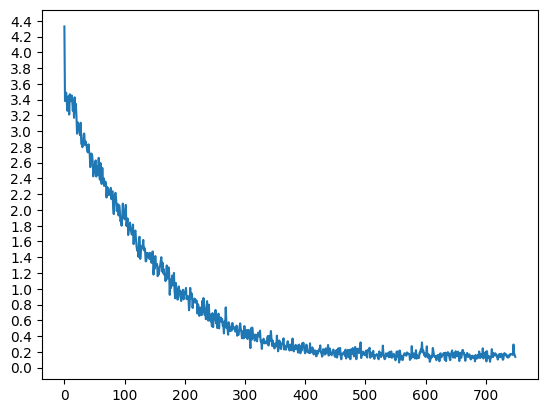

In [29]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

showPlot(train_losses)

In [33]:
evaluateRandomly(encoder1, attn_decoder1)

> 他真是甜心 。
= he s such a sweetheart .
< he s such a sweetheart . <EOS>

> 我不确定 。
= i m not sure .
< i m not sure . <EOS>

> 你是汤姆的朋友，不是吗 ？
= you re tom s friend aren t you ?
< you re a friend friend tom s aren t you ? <EOS>

> 我在谈我的朋友 。
= i m talking about my friend .
< i m talking about my friend . <EOS>

> 你一直忙 。
= you re always busy .
< you re always busy . <EOS>

> 他是我部门的主管 。
= he is the chief of my department .
< he is the chief of my department . <EOS>

> 我不是学生 。
= i m not a student .
< i am not a student . <EOS>

> 能够出一份力太好了 。
= i m glad i could help .
< i m glad i could help . <EOS>

> 他一定会成功 。
= he is bound to succeed .
< he is sure to succeed . <EOS>

> 他比我高一个头 。
= he is taller than me by a head .
< he is a than me by a . <EOS>



In [36]:
output_words = evaluate(encoder1, attn_decoder1, '我是自由')
output_sentence = ' '.join(output_words[0])
print(output_sentence)

i m an optimist . <EOS>


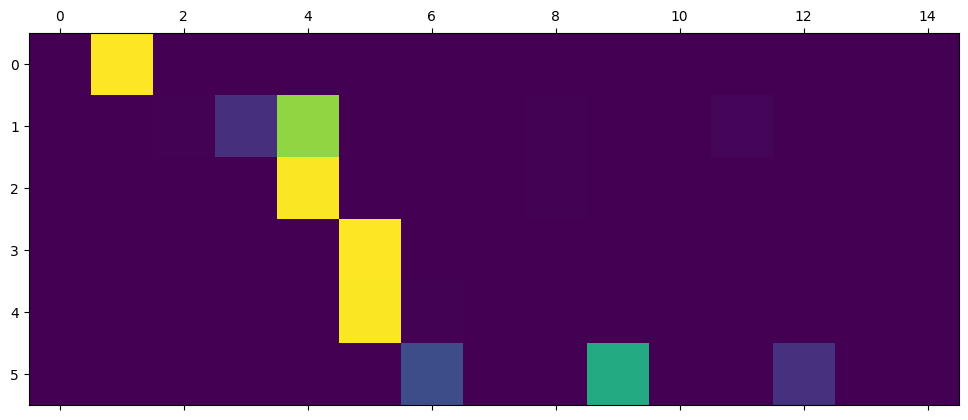

In [48]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "我不确定。")
plt.matshow(attentions.numpy())


In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("我不确定。")
